# Model V35


In [1]:
%pip install tqdm onnx tf2onnx opencv-python

Note: you may need to restart the kernel to use updated packages.


## Data Pipeline

### Data Loading

In [ ]:
import sys
import zipfile
from pathlib import Path

# detect if in Google Colab and mount Google Drive
google_colab = 'google.colab' in sys.modules
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

# string path of dataset .zip file
DATA_ZIP_NAME = 'data.zip' # change this to your dataset zip file name

# extract the dataset
parent_path = Path('/content/gdrive/MyDrive/') if google_colab else Path.cwd()
data_path = parent_path / DATA_ZIP_NAME
with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall()
    # zip_ref will automatically close when exiting the with block

train_dirs = list(Path.cwd().glob('**/train/'))
test_dirs = list(Path.cwd().glob('**/test/'))

print("Train directories:")
for train_dir in train_dirs:
    print(train_dir)

print("\nTest directories:")
for test_dir in test_dirs:
    print(test_dir)


NameError: name 'sys' is not defined

### File Loading Pipeline

In [ ]:
def dataset_file_get_timestamp(file: Path):
    return int(file.stem.split('_')[0])

def dataset_file_get_steering_angle(file: Path):
    return float(file.stem.split('_')[1].replace('-', '.'))

def load_data(directory: Path):
    image_paths = []
    steering_angles = []
    # load image paths from the directory
    for file_path in directory.glob('*.png'):
        image_paths.append(file_path)

    # sort images by the timestamp in their filenames
    image_paths.sort(key=dataset_file_get_timestamp)

    # Extract steering angles from filenames
    for path in image_paths:
        steering_angles.append(dataset_file_get_steering_angle(path))
        
    return image_paths, steering_angles

train_img = []
train_steer = []
test_img = []
test_steer = []

for test_dir in test_dirs:
    test_img_, test_steer_ = load_data(test_dir)
    test_img += test_img_
    test_steer += test_steer_

for train_dir in train_dirs:
    train_img_, train_steer_ = load_data(train_dir)
    train_img += train_img_
    train_steer += train_steer_

print(f"Loaded {len(train_img)} training images "
      f"and {len(test_img)} test images.")

Loaded 40000 training images and 24000 test images.


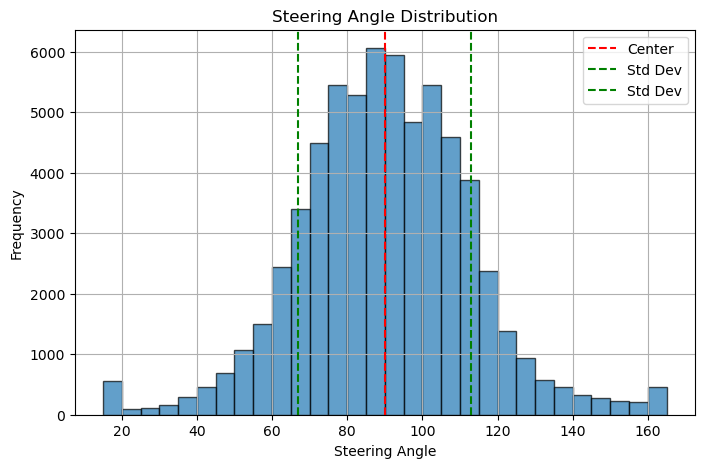

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot steering angle distribution
def plot_steering_angle_distribution(steering_angles):
    steering_angles = np.array(steering_angles)
    stdev = np.std(steering_angles)
    plt.figure(figsize=(8, 5))
    plt.hist(steering_angles, bins=30, alpha=0.7,
             edgecolor='black')
    plt.axvline(x=90, color='red', linestyle='--', label='Center')
    plt.axvline(x=90 + stdev, color='green', linestyle='--', label='Std Dev')
    plt.axvline(x=90 - stdev, color='green', linestyle='--', label='Std Dev')
    plt.xlabel("Steering Angle")
    plt.ylabel("Frequency")
    plt.title("Steering Angle Distribution")
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot steering angle distribution
plot_steering_angle_distribution(train_steer + test_steer)

### Preprocessing Pipeline

2025-04-02 13:45:07.448619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 13:45:07.465985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 13:45:07.470612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 13:45:07.535460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading training data


100%|██████████| 40000/40000 [00:03<00:00, 10430.91it/s]


Loading test data


100%|██████████| 24000/24000 [00:03<00:00, 7412.69it/s] 


Creating training dataset


I0000 00:00:1743626716.964914    1181 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743626717.113731    1181 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743626717.113775    1181 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743626717.116553    1181 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743626717.116591    1181 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Shuffling dataset
Creating testing dataset
Done!


2025-04-02 13:45:36.153623: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1056000000 exceeds 10% of free system memory.


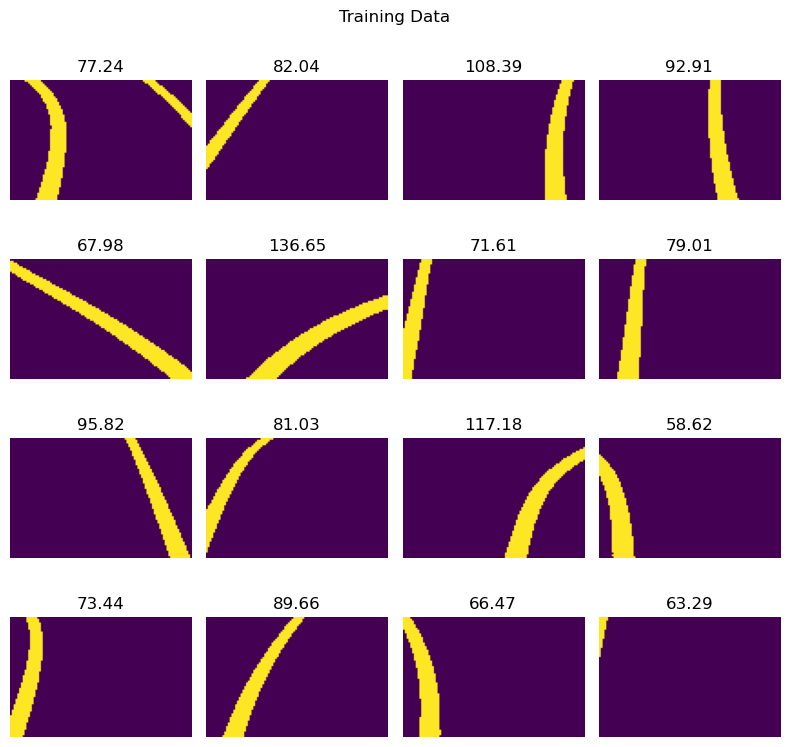

In [ ]:
import cv2 as cv
import tensorflow as tf
import tqdm

BATCH_SIZE = 50
RAND_SEED = 42

SHUFFLE_BUFFER_DIVIDER = 2
PREFETCH_BUFFER_SIZE = tf.data.experimental.AUTOTUNE

def process_image(image_path):
    img = cv.imread(image_path) 
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv, (36, 0, 0), (70, 255,255))
    array = np.array(mask, dtype=np.float32)
    return array

def dataset_pipeline(features, labels, shuffle):
    global BATCH_SIZE, RAND_SEED, SHUFFLE_BUFFER_DIVIDER, PREFETCH_BUFFER_SIZE

    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.repeat()
    if shuffle:
        print("Shuffling dataset")
        dataset = dataset.shuffle(
            buffer_size=len(features) // SHUFFLE_BUFFER_DIVIDER,
            seed=RAND_SEED
        )
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
    return dataset

train_data = []
test_data = []

tqdm.tqdm.write("Loading training data")
# load the images and steering angles into numpy arrays
for path in tqdm.tqdm(train_img):
    train_data.append(process_image(path))

tqdm.tqdm.write("Loading test data")
# loading the testing data
for path in tqdm.tqdm(test_img):
    test_data.append(process_image(path))

## create a dataset from the training data by using the dataset pipeline
print("Creating training dataset")
train_ds = dataset_pipeline(train_data, train_steer, shuffle=True)

## create a dataset from the testing data by using the dataset pipeline
print("Creating testing dataset")
test_ds = dataset_pipeline(test_data, test_steer, shuffle=False)

print("Done!")

# output the first 16 images and steering angles from the dataset
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
# add title to the figure
fig.suptitle('Training Data')
fig.tight_layout()

imgs, steer = next(iter(train_ds)) # get the first batch of images and steering angles

for i in range(16):
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].imshow(imgs[i])
    axs[i//4, i%4].set_title(round(steer[i].numpy(), 2))
plt.tight_layout()
plt.show()

## Model Design

### Neural Network Design

In [ ]:
from keras import layers
from keras import models

IMG_HEIGHT = 66
IMG_WIDTH = 100

conv_params = {
    'kernel_size': (3,3),
    'activation': 'relu',
    'padding': 'same'
}

def conv_block(filters, thick, conv_params):
    block_layers = []
    for _ in range(thick):
        block_layers.append(layers.SeparableConv2D(filters, **conv_params))

    block_layers.append(layers.BatchNormalization())
    block_layers.append(layers.MaxPool2D((2,2)))
    return tuple(block_layers)


model = models.Sequential([
    layers.Input(shape=(66, 100, 1)),

    # Feature Extraction
    *conv_block(8, 1, conv_params),
    *conv_block(12, 1, conv_params),
    *conv_block(16, 1, conv_params),
    *conv_block(32, 2, conv_params),
    *conv_block(48, 2, conv_params),
    layers.Dropout(0.5),

    # Feature Reduction
    layers.GlobalAvgPool2D(),

    # Fully Connected Layers
    layers.Dense(48, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    
    # Output Layer: Steering Angle (0-180 degrees)
    layers.Dense(1, activation='linear')  # Output raw angle
])

# Print Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 66, 100, 8)     │            25 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 33, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 33, 50, 12)     │           180 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 25, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 16, 25, 16)     │           316 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 12, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 8, 12, 32)      │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 8, 12, 32)      │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 4, 6, 48)       │         1,872 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 4, 6, 48)       │         2,784 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 3, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 3, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 48)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,802 (46.10 KB)

 Trainable params: 11,802 (46.10 KB)

 Non-trainable params: 0 (0.00 B)

### Training Parameters

In [ ]:
import tensorflow as tf
from keras import callbacks
from keras import losses
from keras import metrics
from keras import optimizers

## Training parameters
# Specify the various parameters for training
BATCH_DIVIDER = 1
EPOCHS = 100
LEARNING_RATE = 0.002
OPTIMIZER = optimizers.RMSprop(learning_rate=LEARNING_RATE)
LOSS = losses.MeanSquaredError()
METRICS = metrics.RootMeanSquaredError()

## Reduce Learning Rate (RLR) on Plateau parameters
# Reduce learning rate when validation loss doesn't improve for a
# certain number of epochs
RLR_ON = True
RLR_FACTOR = 0.5
RLR_PATIENCE = 10

## Epoch Logger (EL) parameters
# Reduce the number of epochs printed to console to avoid clutter
EL_ON = False
EL_EPOCHS = 10

class EpochLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        '''Logs training progress every 10 epochs.'''
        if (epoch + 1) % EL_EPOCHS == 0:  # Log every 10 epochs
            print(f"Epoch {epoch+1}: Loss = {logs['loss']:.4f},",
                  f"Val Loss = {logs.get('val_loss', 'N/A'):.4f}")


epoch_logger = EpochLogger()
lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=RLR_FACTOR,
    patience=RLR_PATIENCE, verbose=0)

callbacks = []
if RLR_ON:
    callbacks.append(lr_schedule)
if EL_ON:
    callbacks.append(epoch_logger)

fit_params = {
    'epochs': EPOCHS,
    'verbose': 0 if EL_ON else 1,
    'callbacks': callbacks,
}

model.compile(optimizer=OPTIMIZER, loss=LOSS)

## Training

In [ ]:
hist = model.fit(train_ds,
                 steps_per_epoch=len(train_img) // BATCH_SIZE // BATCH_DIVIDER,
                 validation_data=test_ds,
                 validation_steps=len(test_img) // BATCH_SIZE // BATCH_DIVIDER,
                 **fit_params)

Epoch 1/100


I0000 00:00:1743626741.539725    1665 service.cc:146] XLA service 0x7f9e20012b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743626741.539754    1665 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-04-02 13:45:41.591967: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-02 13:45:41.735921: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-04-02 13:45:42.374803: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1596', 8 bytes spill stores, 8 bytes spill loads



 82/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4202.6172

I0000 00:00:1743626746.131596    1665 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


800/800 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1243.2996 - val_loss: 61.2981 - learning_rate: 0.0020
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 184.2678 - val_loss: 33.3642 - learning_rate: 0.0020
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 128.9505 - val_loss: 22.4022 - learning_rate: 0.0020
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 92.9492 - val_loss: 49.0908 - learning_rate: 0.0020
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 66.2100 - val_loss: 24.1471 - learning_rate: 0.0020
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 49.2841 - val_loss: 14.4912 - learning_rate: 0.0020
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 48.6528 - val_loss: 14.0226 - learning_rate: 0.0020
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 39.7161 - val_loss: 10.9588 - learning_rate: 0.0020
Epoch 9/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.9380 - val_loss: 9.6941 - learning_rate:

### Results

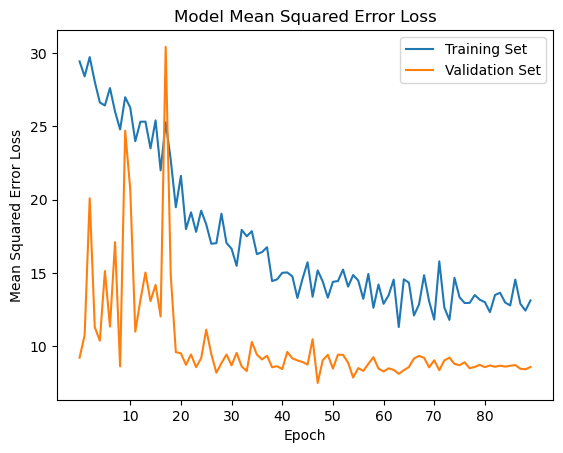

In [ ]:
# Plot the model's history
OFFSET = 10

plt.plot(hist.history['loss'][OFFSET:])
plt.plot(hist.history['val_loss'][OFFSET:])
plt.title('Model Mean Squared Error Loss')
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(OFFSET, len(hist.history['loss'][OFFSET:]), 10))
plt.legend(['Training Set', 'Validation Set'], loc='upper right')
plt.show()

In [ ]:
imgs, steer = next(iter(test_ds)) # get the first batch of images and steering angles

eval_out = model.evaluate(test_ds, steps=50)  # Helps stabilize BatchNorm running statistics
print(f"Test loss: {eval_out}")
prediction = model.predict(imgs[-1].numpy().reshape(1, 66, 100, 1))
print(f"Predicted steering angle: {prediction[0][0]:.2f}")
print(f"Actual steering angle: {steer[-1].numpy():.2f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7866
Test loss: 1.2670005559921265
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
Predicted steering angle: 80.52
Actual steering angle: 80.51


W0000 00:00:1743626487.411925    1140 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743626487.427447    1140 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743626487.432645    1140 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743626487.445197    1140 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743626487.449983    1140 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743626487.460242    1140 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743626487.465360    1140 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743626487.470027    1140 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743626487.475828    1140 gp

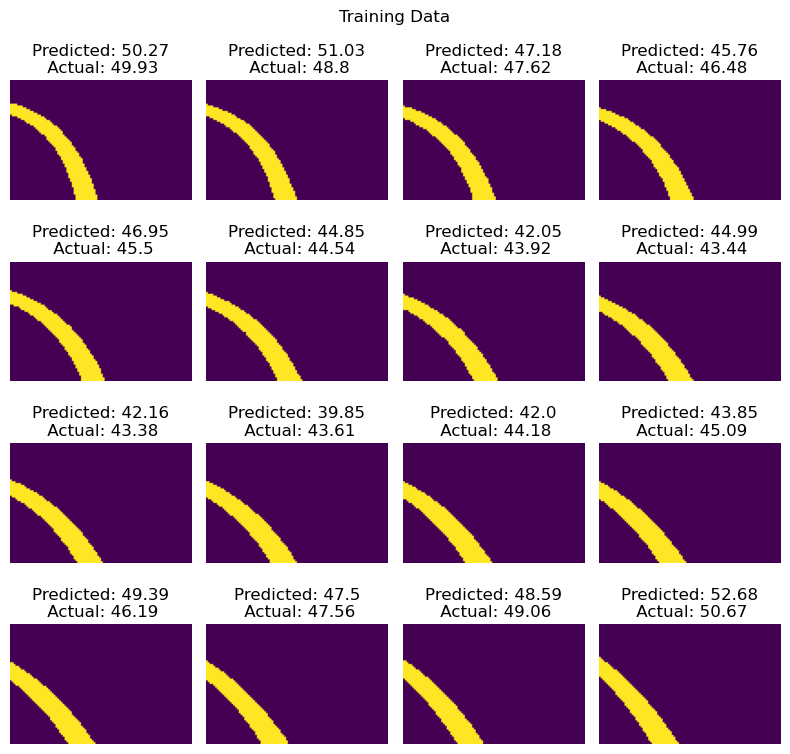

In [ ]:
def display_results():
    # output the first 16 images and steering angles from the test dataset then predict the steering angle for the images
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    # add title to the figure
    fig.suptitle('Training Data')
    fig.tight_layout()
    
    imgs, steer = next(iter(test_ds)) # get the first batch of images and steering angles
    for i in range(16):
        axs[i//4, i%4].axis('off')
        axs[i//4, i%4].imshow(imgs[i])
        axs[i//4, i%4].set_title(round(steer[i].numpy(), 2))
        predicted = model(imgs[i].numpy().reshape(1, 66, 100, 1)) # predict the steering angle for the image
        axs[i//4, i%4].set_title("Predicted: " + str(np.round(predicted[0][0].numpy(), 2))
                                 + "\n Actual: " + str(round(steer[i].numpy(), 2)))
    plt.tight_layout()
    plt.show()

display_results()

In [ ]:
import onnx
import tf2onnx
import tensorflow as tf

model_name = "cnn-v35" # change the name to something more descriptive if you want
model.save(model_name + '.keras')
model.save(model_name + ".h5")
model.output_names = ['output']
input_signature = [tf.TensorSpec([None, 66, 100, 1], tf.float32, name='input')]

onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)

onnx.save(onnx_model, model_name + ".onnx")

I0000 00:00:1743330552.554134   27527 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743330552.555068   27527 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-03-30 03:29:12.555146: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1743330552.555417   27527 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743330552.555441   27527 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743330552.555453   27527 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been bui